# WEASEL+MUSE

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from ActivityDictionary import activities_names, person_all
from pyts.multivariate.transformation import WEASELMUSE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder

In [2]:
def get_filename(person_number, activity_name):
    return f'wristandthigh/0{person_number}_{activity_name}.csv'

Importowanie danych z plików CSV

In [3]:
data = []
act_class = []
for person in person_all:
    for activity in activities_names:
        path = get_filename(person, activity)
        single_table = np.genfromtxt(path, delimiter=',')
        single_table = single_table.transpose()
        data.append(single_table)
        act_class.append(activity)

Badanie długości próbek

In [5]:
lens = []
for i in range(len(data)):
    lens.append(data[i].shape[1])

print(sorted(lens))

[5165, 5391, 5807, 5808, 5820, 5854, 6105, 6157, 6169, 6210, 6228, 6250, 6381, 6460, 6463, 6466, 6503, 6690, 6714, 6728, 6735, 6762, 6781, 6822, 6857, 6858, 6973, 7006, 7075, 7108, 7144, 7154, 7202, 7283, 7334, 7358, 7390, 7409, 7462, 7469, 7470, 7476, 7549, 7556, 7566, 7571, 7598, 7774, 7785, 7789, 7820, 7841, 7850, 7881, 8044, 8050, 8081, 8129, 8170, 8300, 8304, 8400, 8668, 8864, 9255, 9610, 11693, 12939, 13524, 15142, 15283, 15468, 15516, 15700, 15759, 15891, 16160, 16201, 16267, 16284, 16309, 16326, 16326, 16368, 16368, 16370, 16384, 16400, 16401, 16402, 16410, 16415, 16422, 16427, 16428, 16432, 16438, 16449, 16460, 16465, 16466, 16479, 16504, 16519, 16531, 16534, 16534, 16535, 16535, 16541, 16555, 16559, 16563, 16564, 16566, 16566, 16574, 16577, 16582, 16583, 16590, 16594, 16637, 16642, 16645, 16647, 16658, 16666, 16670, 16678, 16678, 16701, 16705, 16708, 16712, 16714, 16717, 16720, 16725, 16738, 16741, 16753, 16754, 16756, 16761, 16763, 16765, 16785, 16786, 16789, 16793, 16794, 1

Ujednolicenie długości próbek 
(wybrano środkowe 50 sekund)

In [6]:
df = []
for i in range(len(data)):
    start = int((lens[i] - 5000) / 2)
    df.append(data[i][:, start:(start + 5000)])
    # df.append(data[i][:, 0:5000])

df = np.array(df)
df.shape

(297, 6, 5000)

Utworzenie zbiorów treningowego i testowego

In [7]:
X_train = df[:243]
X_test = df[243:]
y_train = act_class[:243]
y_test = act_class[243:]

print(X_train.shape)
print(X_test.shape)

(243, 6, 5000)
(54, 6, 5000)


Kodowanie aktywności za pomocą liczb całkowitych

In [8]:
le = LabelEncoder()
le.fit(np.concatenate((y_train, y_test)))

y_train = le.transform(y_train)
y_test = le.transform(y_test)

print(le.classes_)

['downstairs' 'jogging' 'lying' 'sitting' 'standing' 'upstairs' 'walkfast'
 'walkmod' 'walkslow']


### Badanie odstępów między kolejnymi przedziałami okien (mała próbka)

Poniżej przedstawiono działanie klasyfikatora WEASEL+MUSE (dwie możliwości implementacji)

In [22]:
WEASEL_transformer = WEASELMUSE(word_size=4, n_bins=3, window_sizes=[5, 6, 7, 8, 9],
                                anova=True, drop_sum=True,
                                # norm_std=True, (ANOVA alphabet size)
                                chi2_threshold=2, sparse=False)
WEASEL_classifier = LogisticRegression(solver='liblinear', multi_class='ovr')

# Construct and test a WEASEL+MUSE classifier
# via pipeline

# clf = make_pipeline(WEASEL_transformer, WEASEL_classifier)
# clf.fit(X_train, y_train)
# clf_score = clf.score(X_test, y_test)
# print(clf_score)

# or manually
train_data = WEASEL_transformer.fit_transform(X_train, y_train)
WEASEL_classifier.fit(train_data, y_train)

print(train_data.shape)
print(len(WEASEL_transformer.vocabulary_))

test_data = WEASEL_transformer.transform(X_test)
print(WEASEL_classifier.score(test_data, y_test))

ValueError: At least two consecutive quantiles are equal. Consider trying with a smaller number of bins or removing timestamps with low variation.

(Otrzymane podciągi były zbyt podobne do siebie, aby rozdzielić wartości transformaty Fouriera na grupy.)

In [23]:
WEASEL_transformer = WEASELMUSE(word_size=4, n_bins=3, window_sizes=[5, 15, 25, 35, 45],
                                anova=True, drop_sum=True,
                                chi2_threshold=2, sparse=False)
WEASEL_classifier = LogisticRegression(solver='liblinear', multi_class='ovr')

train_data = WEASEL_transformer.fit_transform(X_train, y_train)
WEASEL_classifier.fit(train_data, y_train)

print(train_data.shape)
print(len(WEASEL_transformer.vocabulary_))

test_data = WEASEL_transformer.transform(X_test)
print(WEASEL_classifier.score(test_data, y_test))

(243, 363371)
363371
0.8148148148148148


In [24]:
WEASEL_transformer = WEASELMUSE(word_size=4, n_bins=3, window_sizes=[5, 25, 125, 625, 3125],
                                anova=True, drop_sum=True,
                                chi2_threshold=2, sparse=False)
WEASEL_classifier = LogisticRegression(solver='liblinear', multi_class='ovr')

train_data = WEASEL_transformer.fit_transform(X_train, y_train)
WEASEL_classifier.fit(train_data, y_train)

print(train_data.shape)
print(len(WEASEL_transformer.vocabulary_))

test_data = WEASEL_transformer.transform(X_test)
print(WEASEL_classifier.score(test_data, y_test))

(243, 216558)
216558
0.7777777777777778


### Badanie odstępów między kolejnymi przedziałami okien (duża próbka)

In [159]:
WEASEL_transformer = WEASELMUSE(word_size=4, n_bins=3, window_sizes=[i for i in range(5, 225, 2)], 
                                chi2_threshold=2, sparse=False)
WEASEL_classifier = LogisticRegression(solver='liblinear', multi_class='ovr')

train_data = WEASEL_transformer.fit_transform(X_train, y_train)
WEASEL_classifier.fit(train_data, y_train)

print(train_data.shape)
print(len(WEASEL_transformer.vocabulary_))

test_data = WEASEL_transformer.transform(X_test)
print(WEASEL_classifier.score(test_data, y_test))

(243, 5950539)
5950539
0.8518518518518519


In [9]:
WEASEL_transformer = WEASELMUSE(word_size=4, n_bins=3, window_sizes=[i for i in range(5, 1000, 8)],
                                chi2_threshold=2, sparse=False)
WEASEL_classifier = LogisticRegression(solver='liblinear', multi_class='ovr')

train_data = WEASEL_transformer.fit_transform(X_train, y_train)
WEASEL_classifier.fit(train_data, y_train)

print(train_data.shape)
print(len(WEASEL_transformer.vocabulary_))

test_data = WEASEL_transformer.transform(X_test)
print(WEASEL_classifier.score(test_data, y_test))

(243, 3328175)
3328175
0.8518518518518519


In [161]:
WEASEL_transformer = WEASELMUSE(word_size=4, n_bins=3, window_sizes=[i for i in range(5, 5000, 45)],
                                chi2_threshold=2, sparse=False)
WEASEL_classifier = LogisticRegression(solver='liblinear', multi_class='ovr')

train_data = WEASEL_transformer.fit_transform(X_train, y_train)
WEASEL_classifier.fit(train_data, y_train)

print(train_data.shape)
print(len(WEASEL_transformer.vocabulary_))

test_data = WEASEL_transformer.transform(X_test)
print(WEASEL_classifier.score(test_data, y_test))

(243, 835832)
835832
0.7592592592592593


### Badanie konfiguracji transformera

Poniżej widoczny jest problem wynikający z małej liczby próbek względem ich długości

In [154]:
WEASEL_transformer = WEASELMUSE(word_size=4, n_bins=4, window_sizes=[8, 12, 16, 20],
                                anova=True, drop_sum=True, norm_std=False, 
                                chi2_threshold=2, sparse=False)
WEASEL_classifier = LogisticRegression(solver='liblinear', multi_class='ovr')

ValueError: At least two consecutive quantiles are equal. Consider trying with a smaller number of bins or removing timestamps with low variation.

(Zwiększono zatem liczbę podciągów.)

Test ANOVA + standaryzacja:

In [25]:
WEASEL_transformer = WEASELMUSE(word_size=4, n_bins=3, window_sizes=[i for i in range(5, 100, 10)],
                                anova=True, drop_sum=True, 
                                chi2_threshold=20, sparse=False)
WEASEL_classifier = LogisticRegression(solver='liblinear', multi_class='ovr')

train_data = WEASEL_transformer.fit_transform(X_train, y_train)
WEASEL_classifier.fit(train_data, y_train)

print(train_data.shape)
print(len(WEASEL_transformer.vocabulary_))

test_data = WEASEL_transformer.transform(X_test)
print(WEASEL_classifier.score(test_data, y_test))

(243, 67911)
67911
0.8333333333333334


Test ANOVA (bez usunięcia pierwszego współczynnika transformaty Fouriera, niezalecane) + standaryzacja:

In [26]:
WEASEL_transformer = WEASELMUSE(word_size=4, n_bins=3, window_sizes=[i for i in range(5, 100, 10)],
                                anova=True, drop_sum=False, 
                                chi2_threshold=20, sparse=False)
WEASEL_classifier = LogisticRegression(solver='liblinear', multi_class='ovr')

train_data = WEASEL_transformer.fit_transform(X_train, y_train)
WEASEL_classifier.fit(train_data, y_train)

print(train_data.shape)
print(len(WEASEL_transformer.vocabulary_))

test_data = WEASEL_transformer.transform(X_test)
print(WEASEL_classifier.score(test_data, y_test))

ValueError: At least two consecutive quantiles are equal. Consider trying with a smaller number of bins or removing timestamps with low variation.

Brak testu ANOVA + standaryzacja:

In [27]:
WEASEL_transformer = WEASELMUSE(word_size=4, n_bins=3, window_sizes=[i for i in range(5, 100, 10)],
                                chi2_threshold=20, sparse=False)
WEASEL_classifier = LogisticRegression(solver='liblinear', multi_class='ovr')

train_data = WEASEL_transformer.fit_transform(X_train, y_train)
WEASEL_classifier.fit(train_data, y_train)

print(train_data.shape)
print(len(WEASEL_transformer.vocabulary_))

test_data = WEASEL_transformer.transform(X_test)
print(WEASEL_classifier.score(test_data, y_test))

(243, 81438)
81438
0.8518518518518519


Test ANOVA + brak standaryzacji:

In [28]:
WEASEL_transformer = WEASELMUSE(word_size=4, n_bins=3, window_sizes=[i for i in range(5, 100, 10)],
                                anova=True, drop_sum=True, norm_std=False, 
                                chi2_threshold=20, sparse=False)
WEASEL_classifier = LogisticRegression(solver='liblinear', multi_class='ovr')

train_data = WEASEL_transformer.fit_transform(X_train, y_train)
WEASEL_classifier.fit(train_data, y_train)

print(train_data.shape)
print(len(WEASEL_transformer.vocabulary_))

test_data = WEASEL_transformer.transform(X_test)
print(WEASEL_classifier.score(test_data, y_test))

(243, 75298)
75298
0.7777777777777778


Brak testu ANOVA + brak standaryzacji:

In [29]:
WEASEL_transformer = WEASELMUSE(word_size=4, n_bins=3, window_sizes=[i for i in range(5, 100, 10)],
                                norm_std=False,
                                chi2_threshold=20, sparse=False)
WEASEL_classifier = LogisticRegression(solver='liblinear', multi_class='ovr')

train_data = WEASEL_transformer.fit_transform(X_train, y_train)
WEASEL_classifier.fit(train_data, y_train)

print(train_data.shape)
print(len(WEASEL_transformer.vocabulary_))

test_data = WEASEL_transformer.transform(X_test)
print(WEASEL_classifier.score(test_data, y_test))

(243, 73981)
73981
0.7962962962962963


### Badanie wpływu zwiększenia progu Chi kwadrat

##### Mała próbka
Długości okien (podciągów) o zbyt dużym rozstawieniu

In [8]:
WEASEL_transformer = WEASELMUSE(word_size=4, n_bins=3, window_sizes=[25, 125, 625, 3125],
                                chi2_threshold=2, sparse=False)
WEASEL_classifier = LogisticRegression(solver='liblinear', multi_class='ovr')

clf = make_pipeline(WEASEL_transformer, WEASEL_classifier)
clf.fit(X_train, y_train)
clf_score = clf.score(X_test, y_test)
print(2, len(WEASEL_transformer.vocabulary_), clf_score)

2 142077 0.8148148148148148


In [30]:
for i in range(10, 510, 10):
    try:
        WEASEL_transformer = WEASELMUSE(word_size=4, n_bins=3, window_sizes=[25, 125, 625, 3125],
                                        chi2_threshold=i, sparse=False)
        WEASEL_classifier = LogisticRegression(solver='liblinear', multi_class='ovr')
        
        clf = make_pipeline(WEASEL_transformer, WEASEL_classifier)
        clf.fit(X_train, y_train)
        clf_score = clf.score(X_test, y_test)
        print(i, len(WEASEL_transformer.vocabulary_), clf_score)
        
    except:
        break

10 42934 0.8333333333333334
20 11855 0.8333333333333334
30 5909 0.8518518518518519
40 3728 0.8518518518518519
50 2602 0.8333333333333334
60 1997 0.8333333333333334
70 1548 0.8333333333333334
80 1236 0.8333333333333334
90 1007 0.8333333333333334
100 853 0.7592592592592593
110 735 0.7777777777777778
120 644 0.7777777777777778
130 569 0.7777777777777778
140 506 0.8148148148148148
150 455 0.7962962962962963
160 410 0.7592592592592593
170 371 0.7592592592592593
180 342 0.7592592592592593
190 306 0.7962962962962963
200 278 0.7962962962962963
210 250 0.8148148148148148
220 229 0.7962962962962963
230 210 0.7777777777777778
240 199 0.7407407407407407
250 186 0.7592592592592593
260 174 0.7222222222222222
270 159 0.7037037037037037
280 150 0.7037037037037037
290 136 0.6481481481481481
300 131 0.6481481481481481
310 123 0.7222222222222222
320 114 0.6666666666666666
330 107 0.6851851851851852
340 103 0.6851851851851852
350 97 0.6666666666666666
360 95 0.6666666666666666
370 94 0.7037037037037037
38

##### Średnia próbka
Długości okien (podciągów) o korzystnej odległości

In [9]:
WEASEL_transformer = WEASELMUSE(word_size=4, n_bins=3, window_sizes=[i for i in range(5, 100, 5)],
                                chi2_threshold=2, sparse=False)
WEASEL_classifier = LogisticRegression(solver='liblinear', multi_class='ovr')

clf = make_pipeline(WEASEL_transformer, WEASEL_classifier)
clf.fit(X_train, y_train)
clf_score = clf.score(X_test, y_test)
print(2, len(WEASEL_transformer.vocabulary_), clf_score)

2 1285556 0.8518518518518519


In [31]:
for i in range(10, 510, 10):
    try:
        WEASEL_transformer = WEASELMUSE(word_size=4, n_bins=3, window_sizes=[i for i in range(5, 100, 5)],
                                        chi2_threshold=i, sparse=False)
        WEASEL_classifier = LogisticRegression(solver='liblinear', multi_class='ovr')
        
        clf = make_pipeline(WEASEL_transformer, WEASEL_classifier)
        clf.fit(X_train, y_train)
        clf_score = clf.score(X_test, y_test)
        print(i, len(WEASEL_transformer.vocabulary_), clf_score)
        
    except:
        break

10 472123 0.8518518518518519
20 144779 0.8703703703703703
30 74821 0.8703703703703703
40 48767 0.8518518518518519
50 34614 0.8518518518518519
60 27056 0.8518518518518519
70 21995 0.8518518518518519
80 18212 0.8518518518518519
90 15422 0.8518518518518519
100 13334 0.8518518518518519
110 11834 0.8518518518518519
120 10494 0.8518518518518519
130 9453 0.8333333333333334
140 8608 0.8333333333333334
150 7888 0.8333333333333334
160 7232 0.8148148148148148
170 6650 0.8333333333333334
180 6187 0.8148148148148148
190 5769 0.8148148148148148
200 5404 0.8148148148148148
210 5064 0.8148148148148148
220 4749 0.8148148148148148
230 4472 0.8333333333333334
240 4239 0.8333333333333334
250 4029 0.8333333333333334
260 3840 0.8333333333333334
270 3638 0.8333333333333334
280 3485 0.8148148148148148
290 3322 0.8148148148148148
300 3174 0.8148148148148148
310 3036 0.8148148148148148
320 2916 0.8148148148148148
330 2802 0.8148148148148148
340 2709 0.8148148148148148
350 2628 0.8148148148148148
360 2533 0.8148

##### Duża próbka

In [165]:
WEASEL_transformer = WEASELMUSE(word_size=4, n_bins=3, window_sizes=[i for i in range(5, 500, 4)],
                                chi2_threshold=2, sparse=False)
WEASEL_classifier = LogisticRegression(solver='liblinear', multi_class='ovr')

train_data = WEASEL_transformer.fit_transform(X_train, y_train)
WEASEL_classifier.fit(train_data, y_train)

print(train_data.shape)
print(len(WEASEL_transformer.vocabulary_))

test_data = WEASEL_transformer.transform(X_test)
print(WEASEL_classifier.score(test_data, y_test))

(243, 4840900)
4840900
0.8703703703703703


In [32]:
for i in range(10, 510, 10):
    try:
        WEASEL_transformer = WEASELMUSE(word_size=4, n_bins=3, window_sizes=[i for i in range(5, 500, 4)],
                                        chi2_threshold=i, sparse=False)
        WEASEL_classifier = LogisticRegression(solver='liblinear', multi_class='ovr')
        
        clf = make_pipeline(WEASEL_transformer, WEASEL_classifier)
        clf.fit(X_train, y_train)
        clf_score = clf.score(X_test, y_test)
        print(i, len(WEASEL_transformer.vocabulary_), clf_score)
        
    except:
        break

10 1041463 0.8703703703703703
20 295097 0.8703703703703703
30 153349 0.8703703703703703
40 98877 0.8703703703703703
50 68104 0.8703703703703703
60 52461 0.8703703703703703
70 41859 0.8703703703703703
80 34129 0.8703703703703703
90 28451 0.8703703703703703
100 24457 0.8518518518518519
110 21467 0.8518518518518519
120 18876 0.8518518518518519
130 16784 0.8518518518518519
140 15166 0.8518518518518519
150 13829 0.8518518518518519
160 12611 0.8518518518518519
170 11590 0.8333333333333334
180 10679 0.8333333333333334
190 9882 0.8333333333333334
200 9132 0.8333333333333334
210 8427 0.8333333333333334
220 7850 0.8333333333333334
230 7353 0.8333333333333334
240 6907 0.8333333333333334
250 6483 0.8333333333333334
260 6121 0.8333333333333334
270 5772 0.8333333333333334
280 5465 0.8518518518518519
290 5172 0.8518518518518519
300 4919 0.8518518518518519
310 4693 0.8518518518518519
320 4488 0.8333333333333334
330 4311 0.8333333333333334
340 4138 0.8333333333333334
350 3982 0.8518518518518519
360 384

In [167]:
WEASEL_transformer = WEASELMUSE(word_size=4, n_bins=3, window_sizes=[i for i in range(5, 500, 4)],
                                chi2_threshold=15, sparse=False)
WEASEL_classifier = LogisticRegression(solver='liblinear', multi_class='ovr')

train_data = WEASEL_transformer.fit_transform(X_train, y_train)
WEASEL_classifier.fit(train_data, y_train)

print(train_data.shape)
print(len(WEASEL_transformer.vocabulary_))

test_data = WEASEL_transformer.transform(X_test)
print(WEASEL_classifier.score(test_data, y_test))

(243, 596580)
596580
0.8703703703703703


In [169]:
WEASEL_transformer = WEASELMUSE(word_size=4, n_bins=3, window_sizes=[i for i in range(5, 500, 4)],
                                chi2_threshold=35, sparse=False)
WEASEL_classifier = LogisticRegression(solver='liblinear', multi_class='ovr')

train_data = WEASEL_transformer.fit_transform(X_train, y_train)
WEASEL_classifier.fit(train_data, y_train)

print(train_data.shape)
print(len(WEASEL_transformer.vocabulary_))

test_data = WEASEL_transformer.transform(X_test)
print(WEASEL_classifier.score(test_data, y_test))

(243, 106015)
106015
0.8703703703703703


In [170]:
WEASEL_transformer = WEASELMUSE(word_size=4, n_bins=3, window_sizes=[i for i in range(5, 500, 4)],
                                chi2_threshold=70, sparse=False)
WEASEL_classifier = LogisticRegression(solver='liblinear', multi_class='ovr')

train_data = WEASEL_transformer.fit_transform(X_train, y_train)
WEASEL_classifier.fit(train_data, y_train)

print(train_data.shape)
print(len(WEASEL_transformer.vocabulary_))

test_data = WEASEL_transformer.transform(X_test)
print(WEASEL_classifier.score(test_data, y_test))

(243, 37641)
37641
0.8703703703703703


In [171]:
WEASEL_transformer = WEASELMUSE(word_size=4, n_bins=3, window_sizes=[i for i in range(5, 500, 4)],
                                chi2_threshold=120, sparse=False)
WEASEL_classifier = LogisticRegression(solver='liblinear', multi_class='ovr')

train_data = WEASEL_transformer.fit_transform(X_train, y_train)
WEASEL_classifier.fit(train_data, y_train)

print(train_data.shape)
print(len(WEASEL_transformer.vocabulary_))

test_data = WEASEL_transformer.transform(X_test)
print(WEASEL_classifier.score(test_data, y_test))

(243, 16636)
16636
0.9074074074074074


### Badanie dla wszystkich dostępnych długości okien 
(Chi kwadrat = 50)

In [33]:
WEASEL_transformer = WEASELMUSE(word_size=4, n_bins=3, window_sizes=[i for i in range(5, 5000, 1)],
                                chi2_threshold=50, sparse=False)
WEASEL_classifier = LogisticRegression(solver='liblinear', multi_class='ovr')

train_data = WEASEL_transformer.fit_transform(X_train, y_train)
WEASEL_classifier.fit(train_data, y_train)
print(len(WEASEL_transformer.vocabulary_))

test_data = WEASEL_transformer.transform(X_test)
print(WEASEL_classifier.score(test_data, y_test))

ValueError: At least two consecutive quantiles are equal. Consider trying with a smaller number of bins or removing timestamps with low variation.

### Wizualizacja słów ze słownika symboli (dla osoby nr 026)

(Wymaga wyselekcjonowania charakterystycznych cech -> tendencyjność)

In [47]:
vocab_keys = list(sorted(WEASEL_transformer.vocabulary_.keys()))
len(vocab_keys)

In [36]:
vocab = dct = {key: WEASEL_transformer.vocabulary_[key] for key in vocab_keys[:10]}
vocab_length = 10

In [26]:
table = pd.DataFrame(train_data)
table = table.iloc[:, :10]
table.shape

ValueError: zero-size array to reduction operation maximum which has no identity

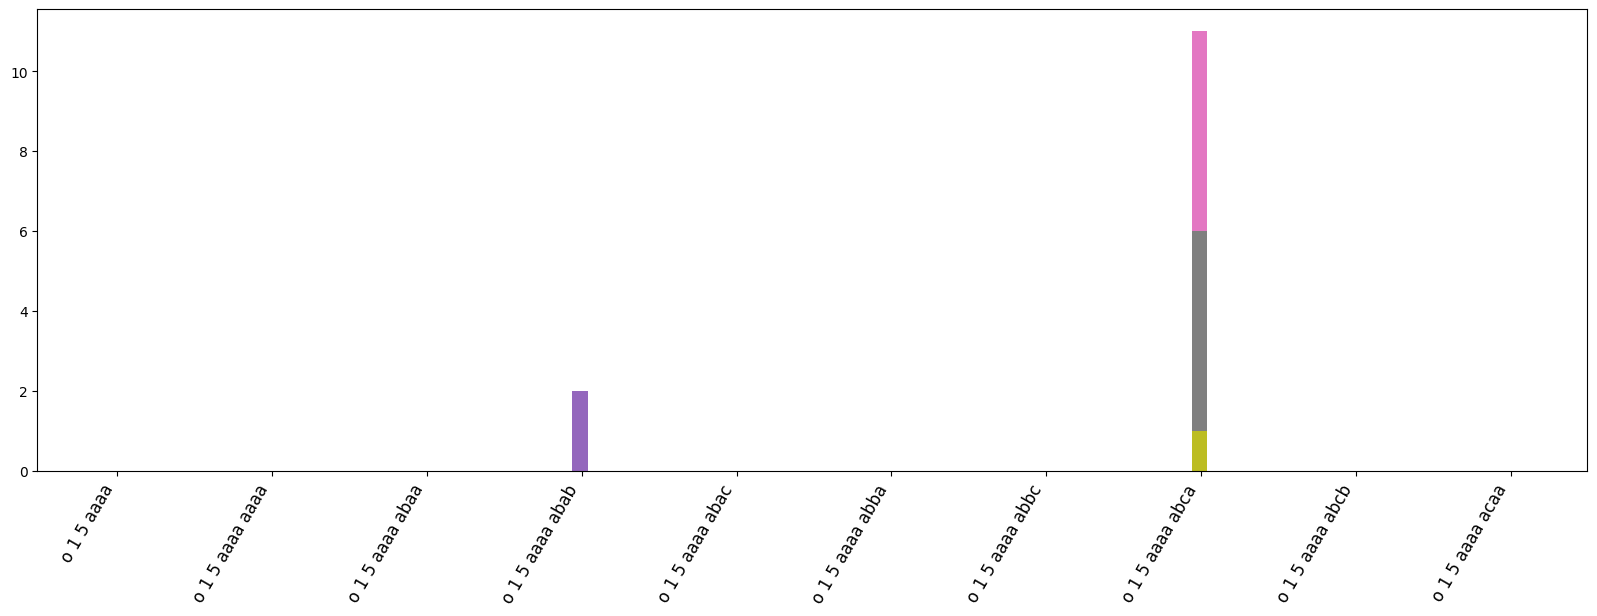

In [45]:
# vocabulary_length = len(WEASEL_transformer.vocabulary_)
# print(vocabulary_length)
width = 0.3
# 
# table = pd.DataFrame(train_data)
# m2 = (table[y_train == 0]).any()
# print (m2)
# a = m2.index[m2]
# print (a)
# 
# table[y_train == 0, [i for i in table.columns if table[(y_train == 0) & (table[i] > 0)].count() > 0]].shape
# print(train_data[y_train == 0, ])


plt.figure(figsize=(20, 6))
for cls in range(len(le.classes_)):
    plt.bar(np.arange(10) - width / 2, train_data[y_train == 0][0],
        width=width, label='First time series in class 0')
# plt.bar(np.arange(10) - width / 2, train_data[y_train == 0][0],
#         width=width, label='First time series in class 0')
    plt.bar(np.arange(10) + width / 2, table[y_train == 1][0],
        width=width, label='First time series in class 1')

plt.xticks(np.arange(10),
           np.vectorize(vocab.get)(np.arange(10)),
           fontsize=12, rotation=60, ha='right')
y_max = np.max(np.concatenate([table[y_train == 0][0],
                               table[y_train == 1][0]]))

plt.yticks(np.arange(y_max + 1), fontsize=12)
plt.xlabel("Words", fontsize=14)
plt.ylabel("Frequencies", fontsize=14)
plt.title("WEASEL+MUSE transformation", fontsize=16)
plt.legend(loc='best', fontsize=10)

plt.subplots_adjust(bottom=0.27)
plt.tight_layout()
plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (20,) and arg 1 with shape (3328175,).

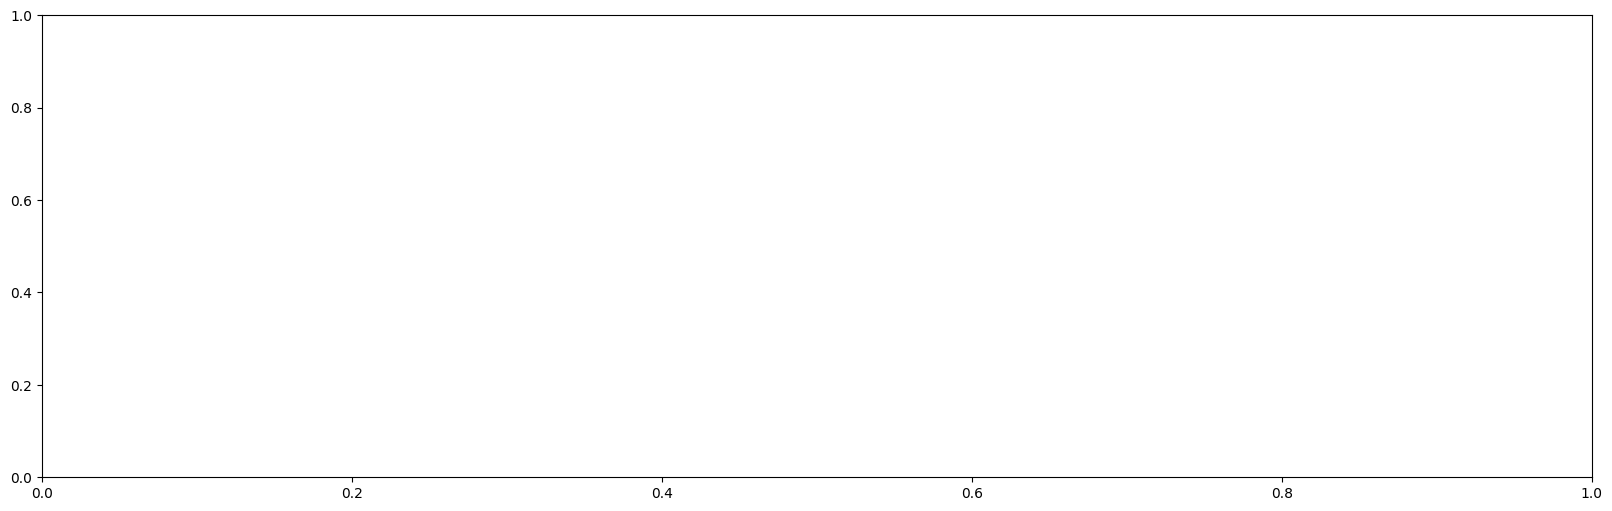